In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Layer, Input

1 Physical GPUs, 1 Logical GPUs


In [2]:
model_name = 'mobilenet'

cifar100_model_feat = np.load(f'./data/CIFAR100_{model_name}_train_feat.npy')
print(cifar100_model_feat.shape)

cifar100_vanilla = np.load(f'./data/CIFAR100_vae_vanilla_{model_name}_encoding_train.npy')
print(cifar100_vanilla.shape)

cifar100_injected = np.load(f'./data/CIFAR100_vae_injected_{model_name}_encoding_train.npy')
print(cifar100_injected.shape)

cifar100_adapted = np.load(f'./data/CIFAR100_vae_adapted_{model_name}_encoding_train.npy')
print(cifar100_adapted.shape)

(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data()

(50000, 1280)
(50000, 1280)
(50000, 1280)
(50000, 1280)


In [3]:
input_shape = (cifar100_model_feat.shape[1],)
batch_size = 128
epochs = 100

In [4]:
model = Sequential( [
    Input(shape=input_shape),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax')
], name=model_name)

model.compile(optimizer=Adam(lr=1e-4),
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

model.fit(x=cifar100_model_feat, y=train_labels, batch_size=batch_size, epochs=epochs)

Model: "mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               12900     
Total params: 832,996
Trainable params: 832,996
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 3s 6ms/step - loss: 4.5853 - accuracy: 0.0186
Epoch 2/100
391/391 [==============================] - 2s 6ms/step - loss: 4.4280 - accuracy: 0.0467
Epoch 3/100
391/391 [==========================

391/391 [==============================] - 4s 10ms/step - loss: 3.3382 - accuracy: 0.2209
Epoch 73/100
391/391 [==============================] - 3s 8ms/step - loss: 3.3381 - accuracy: 0.2238
Epoch 74/100
391/391 [==============================] - 3s 8ms/step - loss: 3.3306 - accuracy: 0.2251
Epoch 75/100
391/391 [==============================] - 4s 9ms/step - loss: 3.3177 - accuracy: 0.2287
Epoch 76/100
391/391 [==============================] - 3s 8ms/step - loss: 3.3088 - accuracy: 0.2297
Epoch 77/100
391/391 [==============================] - 3s 8ms/step - loss: 3.3018 - accuracy: 0.2312
Epoch 78/100
391/391 [==============================] - 3s 9ms/step - loss: 3.3086 - accuracy: 0.2309
Epoch 79/100
391/391 [==============================] - 3s 9ms/step - loss: 3.3097 - accuracy: 0.2339
Epoch 80/100
391/391 [==============================] - 3s 8ms/step - loss: 3.2900 - accuracy: 0.2362
Epoch 81/100
391/391 [==============================] - 3s 9ms/step - loss: 3.2809 - accuracy:

In [5]:
vanilla_model = Sequential([
    Input(shape=input_shape),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax')
], name='vanilla')

vanilla_model.compile(
    optimizer=Adam(lr=1e-4),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

vanilla_model.summary()

vanilla_model.fit(
    x=cifar100_vanilla, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs
)

Model: "vanilla"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 100)               12900     
Total params: 832,996
Trainable params: 832,996
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 4s 11ms/step - loss: 4.7202 - accuracy: 0.0114
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 4.5394 - accuracy: 0.0257
Epoch 3/100
391/391 [==========================

Epoch 71/100
391/391 [==============================] - 4s 11ms/step - loss: 1.0836e-05 - accuracy: 1.0000
Epoch 72/100
391/391 [==============================] - 4s 11ms/step - loss: 8.7954e-06 - accuracy: 1.0000
Epoch 73/100
391/391 [==============================] - 4s 11ms/step - loss: 7.1562e-06 - accuracy: 1.0000
Epoch 74/100
391/391 [==============================] - 4s 11ms/step - loss: 5.8215e-06 - accuracy: 1.0000
Epoch 75/100
391/391 [==============================] - 4s 11ms/step - loss: 4.7284e-06 - accuracy: 1.0000
Epoch 76/100
391/391 [==============================] - 4s 11ms/step - loss: 3.8530e-06 - accuracy: 1.0000
Epoch 77/100
391/391 [==============================] - 4s 11ms/step - loss: 3.1467e-06 - accuracy: 1.0000
Epoch 78/100
391/391 [==============================] - 4s 10ms/step - loss: 2.5672e-06 - accuracy: 1.0000
Epoch 79/100
391/391 [==============================] - 4s 10ms/step - loss: 2.1188e-06 - accuracy: 1.0000
Epoch 80/100
391/391 [===============

In [6]:
injected_model = tf.keras.Sequential([
    Input(shape=input_shape),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax')
], name='injected')

injected_model.compile(
    optimizer=Adam(lr=1e-4),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

injected_model.summary()

injected_model.fit(
    x=cifar100_injected, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs
)

Model: "injected"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               655872    
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               12900     
Total params: 832,996
Trainable params: 832,996
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 5s 11ms/step - loss: 4.7487 - accuracy: 0.0098
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 4.5494 - accuracy: 0.0231
Epoch 3/100
391/391 [=========================

391/391 [==============================] - 4s 11ms/step - loss: 1.8826e-05 - accuracy: 1.0000
Epoch 72/100
391/391 [==============================] - 4s 11ms/step - loss: 1.5309e-05 - accuracy: 1.0000
Epoch 73/100
391/391 [==============================] - 4s 10ms/step - loss: 1.2415e-05 - accuracy: 1.0000
Epoch 74/100
391/391 [==============================] - 4s 11ms/step - loss: 1.0099e-05 - accuracy: 1.0000
Epoch 75/100
391/391 [==============================] - 4s 11ms/step - loss: 8.2331e-06 - accuracy: 1.0000
Epoch 76/100
391/391 [==============================] - 4s 11ms/step - loss: 6.6895e-06 - accuracy: 1.0000
Epoch 77/100
391/391 [==============================] - 4s 11ms/step - loss: 5.4837e-06 - accuracy: 1.0000
Epoch 78/100
391/391 [==============================] - 4s 11ms/step - loss: 4.4514e-06 - accuracy: 1.0000
Epoch 79/100
391/391 [==============================] - 4s 11ms/step - loss: 3.6366e-06 - accuracy: 1.0000
Epoch 80/100
391/391 [============================

In [7]:
adapted_model = Sequential([
    Input(shape=input_shape),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(100, activation='softmax')
],name='adapted' )

adapted_model.compile(
    optimizer=Adam(lr=1e-4),             
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

adapted_model.summary()

adapted_model.fit(
    x=cifar100_adapted, 
    y=train_labels, 
    batch_size=batch_size, 
    epochs=epochs
)

Model: "adapted"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               655872    
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_14 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_15 (Dense)             (None, 100)               12900     
Total params: 832,996
Trainable params: 832,996
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
391/391 [==============================] - 4s 11ms/step - loss: 4.7910 - accuracy: 0.0096
Epoch 2/100
391/391 [==============================] - 4s 11ms/step - loss: 4.5846 - accuracy: 0.0162
Epoch 3/100
391/391 [==========================

391/391 [==============================] - 4s 11ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 73/100
391/391 [==============================] - 5s 11ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 74/100
391/391 [==============================] - 4s 10ms/step - loss: 0.0026 - accuracy: 0.9996
Epoch 75/100
391/391 [==============================] - 4s 11ms/step - loss: 0.3314 - accuracy: 0.9133
Epoch 76/100
391/391 [==============================] - 4s 11ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 77/100
391/391 [==============================] - 4s 11ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 78/100
391/391 [==============================] - 4s 11ms/step - loss: 0.0026 - accuracy: 1.0000 0s - loss: 0
Epoch 79/100
391/391 [==============================] - 4s 11ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 80/100
391/391 [==============================] - 4s 11ms/step - loss: 0.0020 - accuracy: 1.0000
Epoch 81/100
391/391 [==============================] - 4s 11ms/step - lo

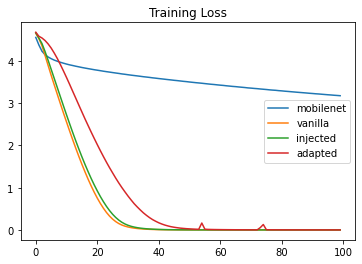

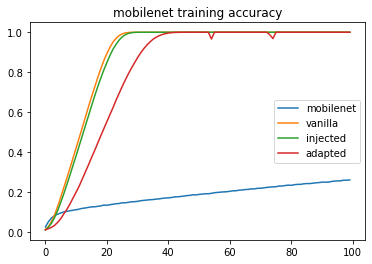

In [8]:
def plot(models, metric):
    for model in models:
        plt.plot(model.history.history['loss'], label=f'{model.name}')
        #plt.plot(model.history.history['val_loss'], label='val_loss', color='red')
    plt.legend()
    plt.title('Training Loss')
    plt.savefig(f'./plots/{model_name}/loss.png')
    plt.show()
   

    for model in models:
        plt.plot(model.history.history[f'{metric}'], label=f'{model.name}')
       # plt.plot(model.history.history[f'val_{metric}'], label=f'val_{metric}', color='red')
    plt.legend()
    plt.title(f'{model_name} training accuracy')
    plt.savefig(f'./plots/{model_name}/accuracy.png')
    plt.show()

        
models = [model, vanilla_model, injected_model, adapted_model]
plot(models, 'accuracy')